# Study 2_1
This notebook

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from src.hrv_epatch.io.tdms import load_tdms_from_path
from scipy.signal import butter, filtfilt, iirnotch, welch

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from src.hrv_epatch.dataset.quality import (
    plot_all_psds,
    compute_spectral_uniqueness,
    compute_recording_quality,
    classify_recordings,
    compute_window_quality_vs_seizure,
)

## Load dataframe

In [2]:
OUT_DIR = Path(r"E:\Speciale - Results\Datastruct")

df_rec = pd.read_csv(
    OUT_DIR / "recordings_index.csv",
    parse_dates=["recording_start", "recording_end"],
)

df_evt = pd.read_csv(
    OUT_DIR / "seizure_events.csv",
    parse_dates=["absolute_start", "absolute_end"],
)
# Sanity check
# print(df_rec.head(), df_evt.head())

STUDY2_OUT = OUT_DIR / "_analysis" / "study2"
STUDY2_OUT.mkdir(parents=True, exist_ok=True)

## Recording-level signal preprocessing and spectral overview
This section characterises the raw ePatch ECG recordings at the level of complete recordings.
First, each recording is preprocessed using a standardised pipeline (Study 2.1), including removal of initial and final margins, band-pass filtering (0.5–40 Hz) and 50 Hz notch filtering.
Power spectral density (PSD) estimates are then computed for each recording in order to visualise the overall spectral content and to identify atypical recordings with markedly different frequency characteristics.

In [ ]:
# PSD overview (all recordings in one figure)
psd_fig = plot_all_psds(
    df_rec,
    outpath=STUDY2_OUT / "all_recordings_psd.png",
    channel_hint="EKG",
    max_freq=100.0,
)
# psd_fig.savefig(STUDY2_OUT / "all_recordings_psd.png", dpi=300, bbox_inches="tight")

# (optional) spectral uniqueness score per recording
df_spec = compute_spectral_uniqueness(df_rec)
df_spec.to_csv(STUDY2_OUT / "recording_spectral_uniqueness.csv", index=False)


AttributeError: 'NoneType' object has no attribute 'savefig'

## Recording-level signal quality metrics
Based on the preprocessed ECG, a set of window-based metrics is computed for each recording.
The signal is divided into short non-overlapping windows (e.g. 10 s), and for each window the standard deviation, amplitude range and presence of flatline periods are quantified.
Windows with extremely high variability are marked as noise bursts, while windows with saturated amplitude values are used to detect clipping.
In parallel, spectral band powers are derived for low-frequency drift, the QRS-dominated band, and high-frequency noise.
Aggregating these features across windows yields a compact set of recording-level descriptors (median and extreme values, fractions of flat/noisy/clipped windows, and band-power ratios) that summarise both the amplitude dynamics and spectral composition of each recording.

In [ ]:
df_quality = compute_recording_quality(df_rec)

# merge spectral_uniqueness in, if df_spec has recording_uid
df_quality = df_quality.merge(
    df_spec[["recording_uid", "spectral_uniqueness_score"]],
    on="recording_uid",
    how="left",
)

  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:244: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = float(np.trapz(p, f) + 1e-12)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:247: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(p[(f >= 0.5) & (f < 5.0)], f[(f >= 0.5) & (f < 5.0)])
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:250: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(p[(f >= 5.0) & (f < 25.0)], f[(f >= 5.0) & (f < 25.0)])
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:253: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrat

## Automatic categorisation of recording quality
The recording-level metrics are combined into a heuristic quality categorisation. Thresholds on the fraction of flatline windows, the proportion of noise bursts and the relative QRS band power are used to assign each recording to `good`, `borderline`, or `poor` signal quality. This categorisation is used to document the range of signal conditions in the dataset and to support later sensitivity analyses.

In [ ]:
df_quality = classify_recordings(df_quality)

# Save primary overview
df_quality.to_csv(STUDY2_OUT / "recording_quality_overview.csv", index=False)

# Select recording_uid for RR validation (used later)
good_recs = df_quality[df_quality["include_for_rr"]]
good_recs[["recording_uid", "patient_id", "recording_id"]].to_csv(
    STUDY2_OUT / "good_recordings_for_rr.csv",
    index=False,
)

## Exploratory clustering of recording quality profiles

In [ ]:
feature_cols = [
    "win_std_median",
    "win_std_p99",
    "frac_noiseburst_windows",
    "frac_flatline_windows",
    "qrs_power_ratio",
    "hf_ratio",
    "lf_ratio",
    "psd_kurtosis",
    "spectral_uniqueness_score", 
]

df_feat = df_quality.dropna(subset=feature_cols).copy()
X = df_feat[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

df_feat["quality_cluster_kmeans"] = cluster_labels

df_quality_clustered = df_quality.merge(
    df_feat[["recording_uid", "quality_cluster_kmeans"]],
    on="recording_uid",
    how="left",
)

df_quality_clustered.to_csv(
    STUDY2_OUT / "recording_quality_clusters.csv",
    index=False,
)

# discriptive statistics per cluster
cluster_summary = df_quality_clustered.groupby("quality_cluster_kmeans")[
    ["win_std_median", "frac_noiseburst_windows", "qrs_power_ratio"]
].describe()
cluster_summary.to_csv(STUDY2_OUT / "recording_quality_clusters_summary.csv")

# Boxplots for the report
plt.figure(figsize=(14, 6))
for idx, cluster in enumerate(
    sorted(df_quality_clustered["quality_cluster_kmeans"].dropna().unique()), start=1
):
    plt.subplot(1, 3, idx)
    cluster_data = df_quality_clustered[
        df_quality_clustered["quality_cluster_kmeans"] == cluster
    ]
    cluster_data[["win_std_median", "frac_noiseburst_windows", "qrs_power_ratio"]].boxplot()
    plt.title(f"Cluster {cluster} (n={len(cluster_data)})")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(STUDY2_OUT / "recording_quality_clusters_boxplots.png", dpi=300)
plt.show()

c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Window-level signal quality: baseline vs. seizure
To characterise how signal quality varies around seizures, the recordings are partitioned into short windows, and each window is labelled as either baseline or seizure depending on overlap with the seizure annotations.

In [ ]:
df_win = compute_window_quality_vs_seizure(df_rec, df_evt)

# save for later analysis / plots
df_win_out = STUDY2_OUT / "window_quality_baseline_vs_seizure.csv"
df_win.to_csv(df_win_out, index=False)

# --- patient-specific comparison ---
std_compare = df_win.groupby(["patient_id", "context"])["std"].median().unstack()
range_compare = df_win.groupby(["patient_id", "context"])["range"].median().unstack()
noise_compare = df_win.groupby(["patient_id", "context"])["is_noiseburst"].mean().unstack()

std_compare.to_csv(STUDY2_OUT / "window_std_median_per_patient.csv")
range_compare.to_csv(STUDY2_OUT / "window_range_median_per_patient.csv")
noise_compare.to_csv(STUDY2_OUT / "window_noiseburst_rate_per_patient.csv")

# --- global values (for text in the results section) ---
print("Global STD median:\n", df_win.groupby("context")["std"].median())
print("\nGlobal RANGE median:\n", df_win.groupby("context")["range"].median())
print("\nGlobal NOISEBURST rate:\n", df_win.groupby("context")["is_noiseburst"].mean())

# Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(x="context", y="std", data=df_win)
plt.title("Window-level standard deviation by context")
plt.ylabel("Standard deviation (a.u.)")
plt.xlabel("")
plt.tight_layout()
plt.savefig(STUDY2_OUT / "window_std_boxplot_baseline_vs_seizure.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x="context", y="range", data=df_win)
plt.title("Window-level amplitude range by context")
plt.ylabel("Amplitude range (a.u.)")
plt.xlabel("")
plt.tight_layout()
plt.savefig(STUDY2_OUT / "window_range_boxplot_baseline_vs_seizure.png", dpi=300)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    x=["baseline", "seizure"],
    y=df_win.groupby("context")["is_noiseburst"].mean().values,
)
plt.title("Noiseburst rate by context")
plt.ylabel("Fraction of windows labelled as noiseburst")
plt.tight_layout()
plt.savefig(STUDY2_OUT / "window_noiseburst_rate_barplot.png", dpi=300)
plt.show()

# Eksempel-figur for én patient (valgfri)
example_patient = 6
rec_ids = df_win[df_win["patient_id"] == example_patient]["recording_uid"].unique()

for rec in rec_ids[:1]:
    df_r = df_win[df_win["recording_uid"] == rec]

    plt.figure(figsize=(14, 5))
    plt.plot(df_r["win_start_s"], df_r["std"], label="STD")
    plt.scatter(
        df_r[df_r["context"] == "seizure"]["win_start_s"],
        df_r[df_r["context"] == "seizure"]["std"],
        color="red",
        label="seizure windows",
    )
    plt.title(f"Window STD over time – recording {rec} (patient {example_patient})")
    plt.xlabel("Time (s)")
    plt.ylabel("STD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(
        STUDY2_OUT / f"window_std_timecourse_patient{example_patient}_rec{rec}.png",
        dpi=300,
    )
    plt.show()

NameError: name 'sig_raw' is not defined

## Construction of the 60-s segment index
In order to support signal quality assessment and seizure-related analyses in later studies, the recordings are partitioned into fixed-length windows.
Using the recording and seizure index from Study 2, a segment index is constructed with 60 s windows labelled as baseline, seizure or other relevant contexts.
For each segment, the index stores the patient identifier, recording identifier, absolute time and context label.
The index is exported as a separate CSV file and reused as a common reference structure in Studies 3–5.

In [5]:
from src.hrv_epatch.dataset.segments import build_segment_index

# Segmenterings-parameter (bruges i senere studier)
SEG_WIN_S = 60.0  # 60 s vinduer med den step/overlap som build_segment_index bruger

df_seg = build_segment_index(df_rec, df_evt, window_s=SEG_WIN_S)

# Simpel kontrol
df_seg.head(), len(df_seg)


(   segment_id  patient_id enrollment_id  recording_uid       segment_start  \
 0           0           1           NaN              0 2016-02-22 11:04:14   
 1           1           1           NaN              0 2016-02-22 11:05:14   
 2           2           1           NaN              0 2016-02-22 11:06:14   
 3           3           1           NaN              0 2016-02-22 11:07:14   
 4           4           1           NaN              0 2016-02-22 11:08:14   
 
           segment_end     label  
 0 2016-02-22 11:05:14  baseline  
 1 2016-02-22 11:06:14  baseline  
 2 2016-02-22 11:07:14  baseline  
 3 2016-02-22 11:08:14  baseline  
 4 2016-02-22 11:09:14  baseline  ,
 195806)

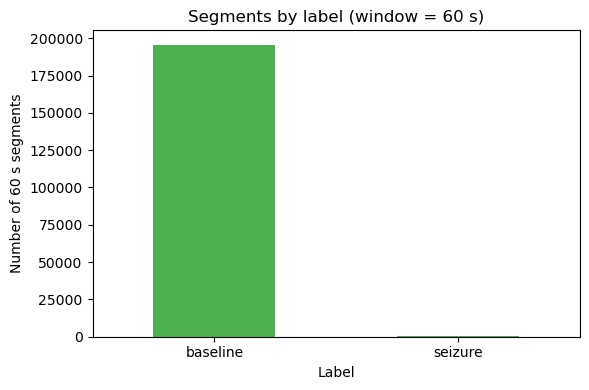

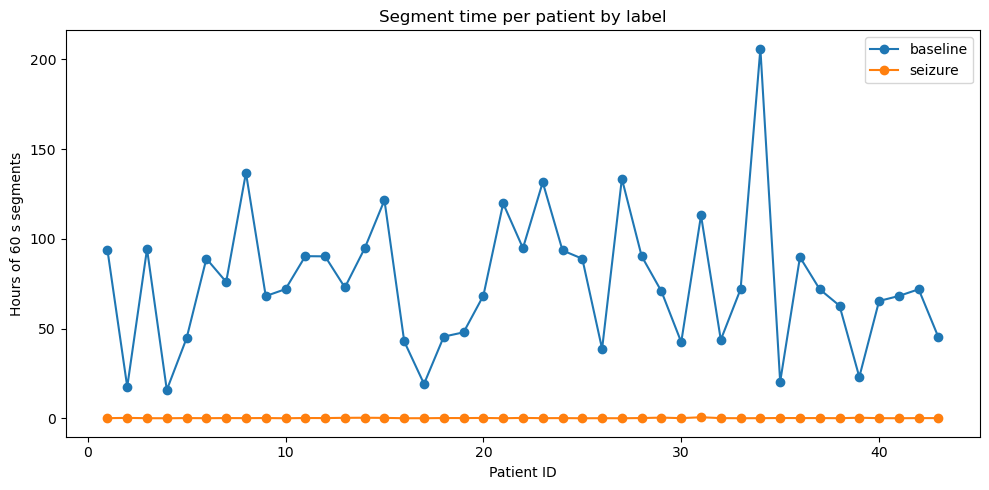

label
baseline    195490
seizure        316
Name: count, dtype: int64


In [9]:
from src.hrv_epatch.plots.plotstyle import palette
import matplotlib.pyplot as plt
# Fordeling af labels
seg_counts = df_seg["label"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
seg_counts.plot(kind="bar", color=palette["primary"])
plt.ylabel("Number of 60 s segments")
plt.xlabel("Label")
plt.title(f"Segments by label (window = {SEG_WIN_S:.0f} s)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Segment-tid per patient og label
seg_per_patient = (
    df_seg
    .groupby(["patient_id", "label"])
    .size()
    .rename("n_segments")
    .reset_index()
)

seg_per_patient["duration_h"] = (
    seg_per_patient["n_segments"] * SEG_WIN_S / 3600.0
)

plt.figure(figsize=(10, 5))
for label in sorted(seg_per_patient["label"].unique()):
    subset = seg_per_patient[seg_per_patient["label"] == label]
    plt.plot(
        subset["patient_id"],
        subset["duration_h"],
        marker="o",
        linestyle="-",
        label=label,
    )

plt.xlabel("Patient ID")
plt.ylabel("Hours of 60 s segments")
plt.title("Segment time per patient by label")
plt.legend()
plt.tight_layout()
plt.show()

seg_counts = df_seg["label"].value_counts()
print(seg_counts)

# seg_counts.to_csv(STUDY2_OUT / "segment_counts_global.csv", index=False)


In [ ]:
SEG_OUT = OUT_DIR / f"segment_index_{int(SEG_WIN_S)}s.csv"
df_seg.to_csv(SEG_OUT, index=False)
print("Saved segment index to:", SEG_OUT)
